In [29]:
import os
from itertools import product

import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [30]:
CSV_PATH = "/home/28i_mel@lab.graphicon.ru/mnt/dione/28i_mel/DBCNN-results/"
get_base_line = lambda dataset, iter: f"{dataset}_VGG-16+relu_PGD={iter}.csv"
sns.set_color_codes('deep')
sns.set_theme()

In [31]:
activations = [
    "relu",
    "Frelu_elu",
]
archs = [
    "VGG-16",
]
prunes = [ 
    {
        'percent': .0,
        'method': '',
    }, 
    {
        'percent': .1,
        'method': 'pls',
    },
    {
        'percent': .1,
        'method': 'l1',
    },
    {
        'percent': .1,
        'method': 'l2',
    }
]
cayleys = [
    None,
    'cayley',
    'cayley2',
    'cayley3',
    'cayley4'
]

gradnorm = [
    
    False,
    True,
]
resizers = [
    True,
    False
]

datasets = ["KonIQ-10k", "NIPS"]

In [32]:
available_results = os.listdir(CSV_PATH)

In [ ]:
class Scores:
    def __init__(self, **kwargs):
        self.nips_df, self.koniq_df = kwargs.get("nips_df", None), kwargs.get("koniq_df", None)
        self.iters = kwargs.get("iters", 1)
    def fit(self, col):
        if self.nips_df is not None:
            # self.scaler_nips = MinMaxScaler()
            # self.scaler_nips.fit(self.nips_df[col].to_numpy().reshape(-1,1))
            self.nips_min = self.nips_df[col].min()
            self.nips_max = self.nips_df[col].max()
        if self.koniq_df is not None:
            # self.scaler_koniq = MinMaxScaler()
            # self.scaler_koniq.fit(self.koniq_df[col].to_numpy().reshape(-1,1))
            self.koniq_min = self.koniq_df[col].min()
            self.koniq_max = self.koniq_df[col].max()


    def scale(self, clear_val, attacked_val, dataset):
        if dataset=='NIPS':
            # scaled_clear_val = self.scaler_nips.transform(clear_val.reshape(-1,1))
            # scaled_attacked_val = self.scaler_nips.transform(attacked_val.reshape(-1,1))
            scaled_clear_val = ((clear_val - self.nips_min)/(self.nips_max - self.nips_min))
            scaled_attacked_val = ((attacked_val - self.nips_min)/(self.nips_max - self.nips_min))
            print("min", self.nips_min, 'max', self.nips_max)
        elif dataset=='KonIQ-10k':
            # scaled_clear_val = self.scaler_koniq.transform(clear_val.reshape(-1, 1))
            # scaled_attacked_val = self.scaler_koniq.transform(attacked_val.reshape(-1,1))
            scaled_clear_val = ((clear_val - self.koniq_min)/(self.koniq_max - self.koniq_min))
            scaled_attacked_val = ((attacked_val - self.koniq_min)/(self.koniq_max - self.koniq_min))
            print('min', self.koniq_min, 'max', self.koniq_max)
        return scaled_clear_val, scaled_attacked_val
    
    def get_abs_gain(self, clear_val, attacked_val, dataset='NIPS'):
        if isinstance(clear_val, pd.DataFrame) or isinstance(clear_val, pd.Series):
            clear_val = clear_val.to_numpy()
        if isinstance(attacked_val, pd.DataFrame) or isinstance(attacked_val, pd.Series):
            attacked_val = attacked_val.to_numpy()
        
        scaled_clear_val, scaled_attacked_val = self.scale(clear_val, attacked_val, dataset)
        # print(scaled_clear_val.min(), scaled_clear_val.max())
        # print(scaled_attacked_val, scaled_clear_val)
        return (scaled_attacked_val - scaled_clear_val).mean()

    def get_r_score(self, clear_val, attacked_val, dataset='NIPS'):
        if isinstance(clear_val, pd.DataFrame) or isinstance(clear_val, pd.Series):
            clear_val = clear_val.to_numpy()
        if isinstance(attacked_val, pd.DataFrame) or isinstance(attacked_val, pd.Series):
            attacked_val = attacked_val.to_numpy()
        scaled_clear_val, scaled_attacked_val = self.scale(clear_val, attacked_val, dataset)
        beta1 = max(scaled_clear_val)
        beta0 = min(scaled_clear_val)
        print(min(scaled_clear_val), max(scaled_clear_val), dataset)
        return np.mean(
            np.log10(
                np.maximum(beta1-scaled_attacked_val, scaled_clear_val-beta0)/np.abs(scaled_attacked_val-scaled_clear_val)
                )
            )

In [34]:
def draw_plot(iterations=1, ax_rows=10, ax_cols=2, figsize=(14,50), wsapce=0.2, hspace=0.3):
    epsilons = [ 2, 4, 6, 8, 10 ]
    attack_type = "PGD"

    baseline_df_nips = pd.read_csv(os.path.join(CSV_PATH, get_base_line('NIPS', iterations)))
    baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, get_base_line('KonIQ-10k', iterations)))
    scores = Scores(nips_df=baseline_df_nips, koniq_df=baseline_df_koniq)
    scores.fit(col='clear_val')

    baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
    for i, df in enumerate((baseline_df_koniq, baseline_df_nips)):
        for eps in epsilons:
            baseLine.loc[len(baseLine)] = {
                                        'eps': f"{eps}/255",
                                        'abs_gain': 
                                            scores.get_abs_gain(df['clear_val'], 
                                                                df[f'attacked_val_eps={eps}'],
                                                                dataset=datasets[i]),
                                        'r_score': 
                                            scores.get_r_score(df['clear_val'], 
                                                            df[f'attacked_val_eps={eps}'], 
                                                            dataset=datasets[i]),
                                        'dataset': datasets[i]
                                        }

    fig, axis = plt.subplots(ax_rows, ax_cols, figsize=figsize, sharey=False)
    plt.subplots_adjust(wspace=wsapce, hspace=hspace)
    # axis = axis.flatten()
    plot_idx = 0

    arch_title = None

    for (
        # dataset,
        cayley,
        is_gradnorm_regularization,
        prune,
        arch,
        activation,
        is_resize,
        ) in product(
                        # datasets,
                        cayleys, 
                        gradnorm,
                        prunes,
                        archs,
                        activations,
                        resizers,
                        ):
        data = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
        for dataset in datasets:
            cl = f'+{cayley}' if cayley else ''
            gr = f'+gr' if is_gradnorm_regularization else ''
            resize = f'+resize=498x664' if is_resize else ''
            prune_status = f"+{prune['percent']}_{prune['method']}" if prune['percent'] else ''
            arch_status = f'{arch}{cl}{gr}{prune_status}+{activation}'
            path = "{}_{}_{}={}{}.csv".format(
                                            dataset,
                                            arch_status,
                                            attack_type,
                                            iterations,
                                            resize
                                            )
            # print(path)
            if path not in available_results:
                break
            
            path = os.path.join(CSV_PATH, path)
            df = pd.read_csv(path, index_col=False)
            
            arch_title = f"{arch_status}{resize} {attack_type}-{iterations}"
            for eps in epsilons:
                data.loc[len(data)] = {
                        'eps': f'{int(eps)}/255',
                        'abs_gain': scores.get_abs_gain(df['clear_val'], 
                                                        df[f'attacked_val_eps={eps}'],
                                                        dataset=dataset),
                        'r_score': scores.get_r_score(df['clear_val'], 
                                                    df[f'attacked_val_eps={eps}'], 
                                                    dataset=dataset),
                        'dataset': dataset,
                }

        
        if len(data) > 0:
            sns.lineplot(data=baseLine, x='eps', y='abs_gain', linewidth=1.5, linestyle='--',
                        legend='full', hue='dataset', ax=axis[plot_idx][0]
                        )
            sns.lineplot(data=data, x='eps', y='abs_gain', 
                        legend="full", hue="dataset", ax=axis[plot_idx][0])
            
            sns.lineplot(data=baseLine, x='eps', y='r_score', linewidth=1.5, linestyle='--',
                        legend='full', hue='dataset', ax=axis[plot_idx][1]
                        )
            sns.lineplot(data=data, x='eps', y='r_score', 
                        legend="full", hue="dataset", ax=axis[plot_idx][1])
            axis[plot_idx][0].set_title(arch_title)
            axis[plot_idx][1].set_title(arch_title)
            plot_idx += 1

    plt.show()

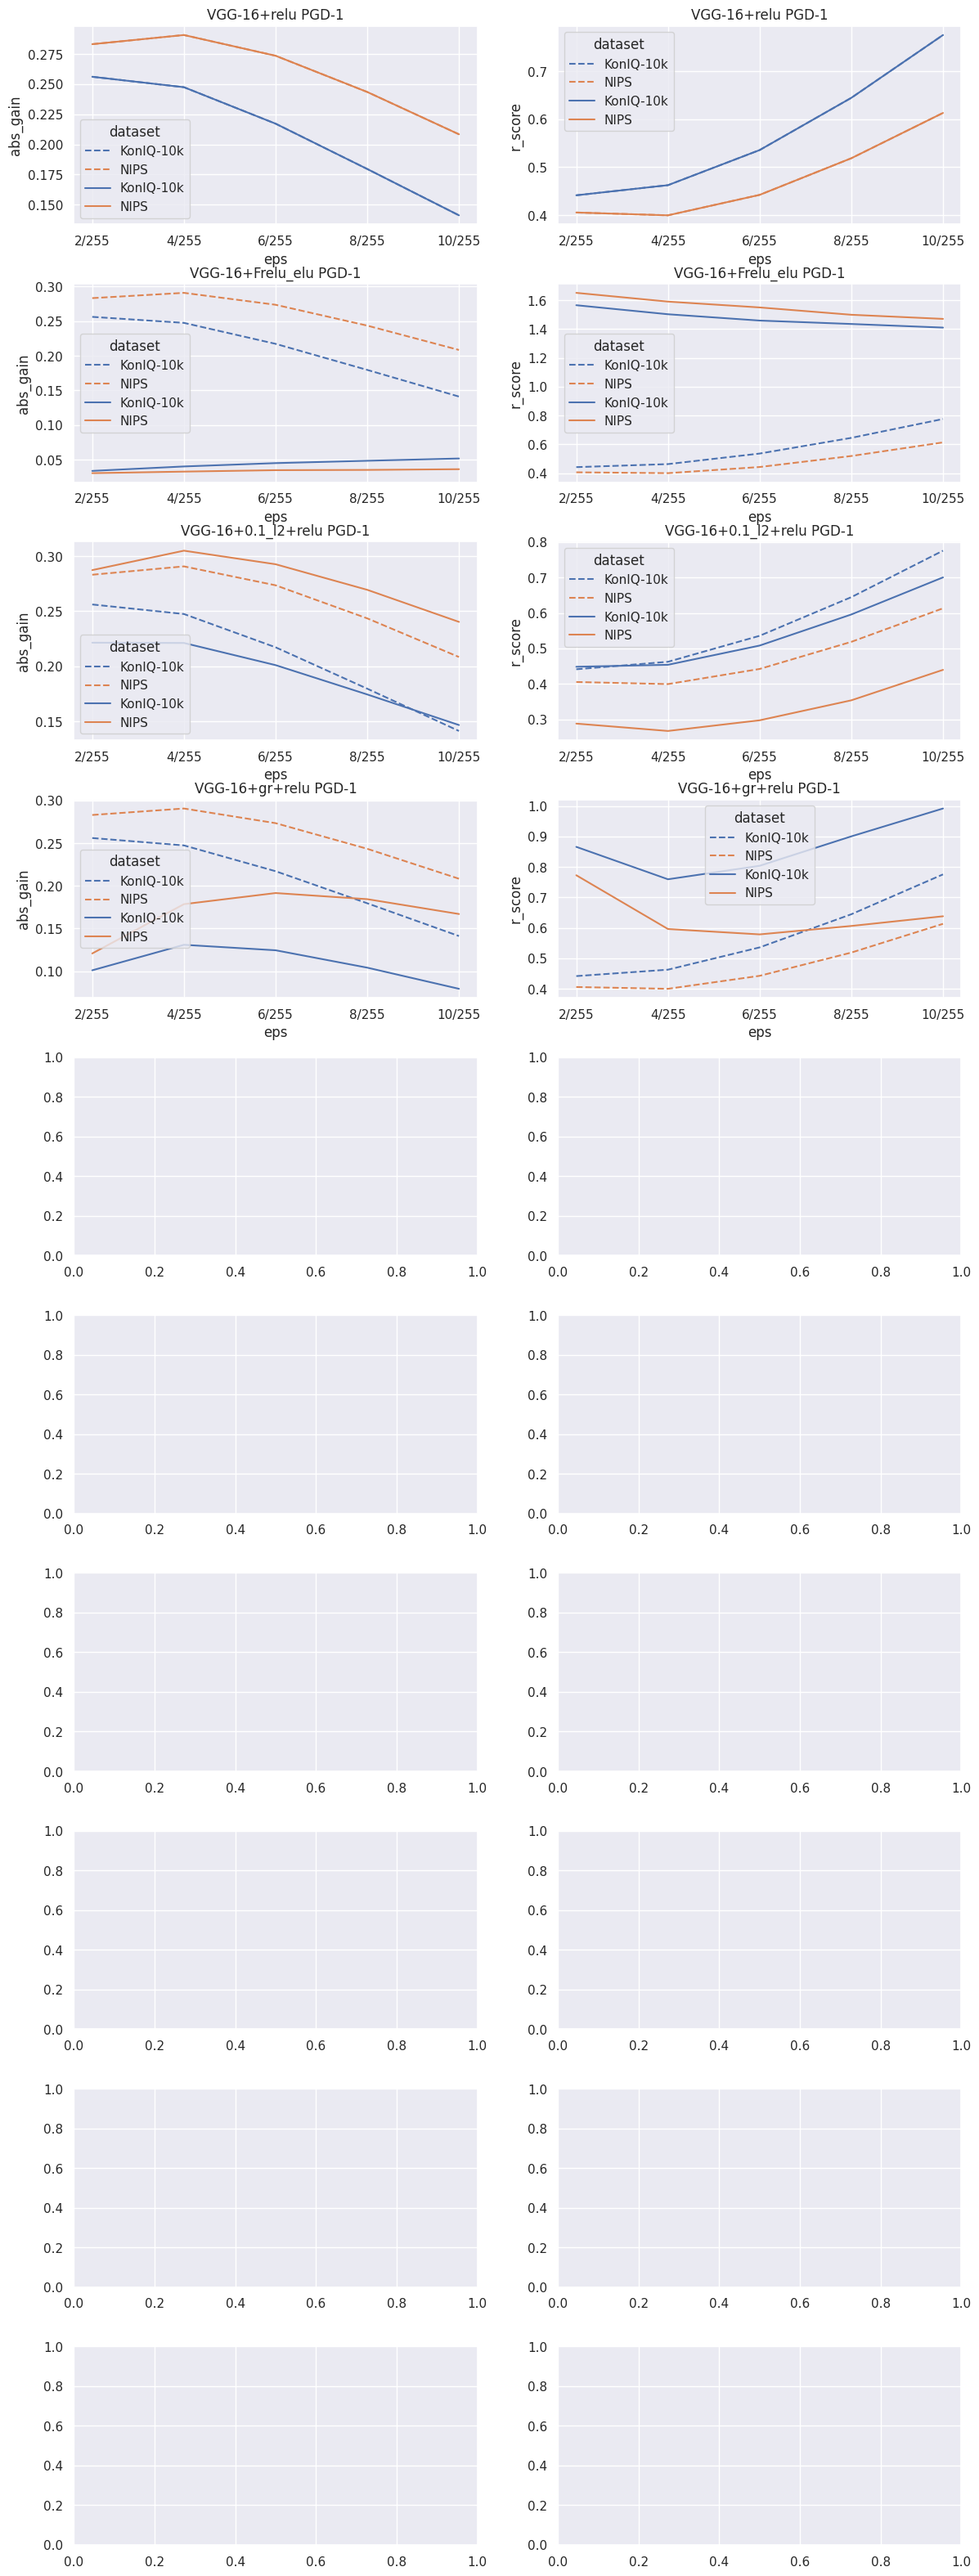

In [35]:
draw_plot(iterations=1, ax_rows=10, ax_cols=2, figsize=(14,40), wsapce=0.2, hspace=0.3)

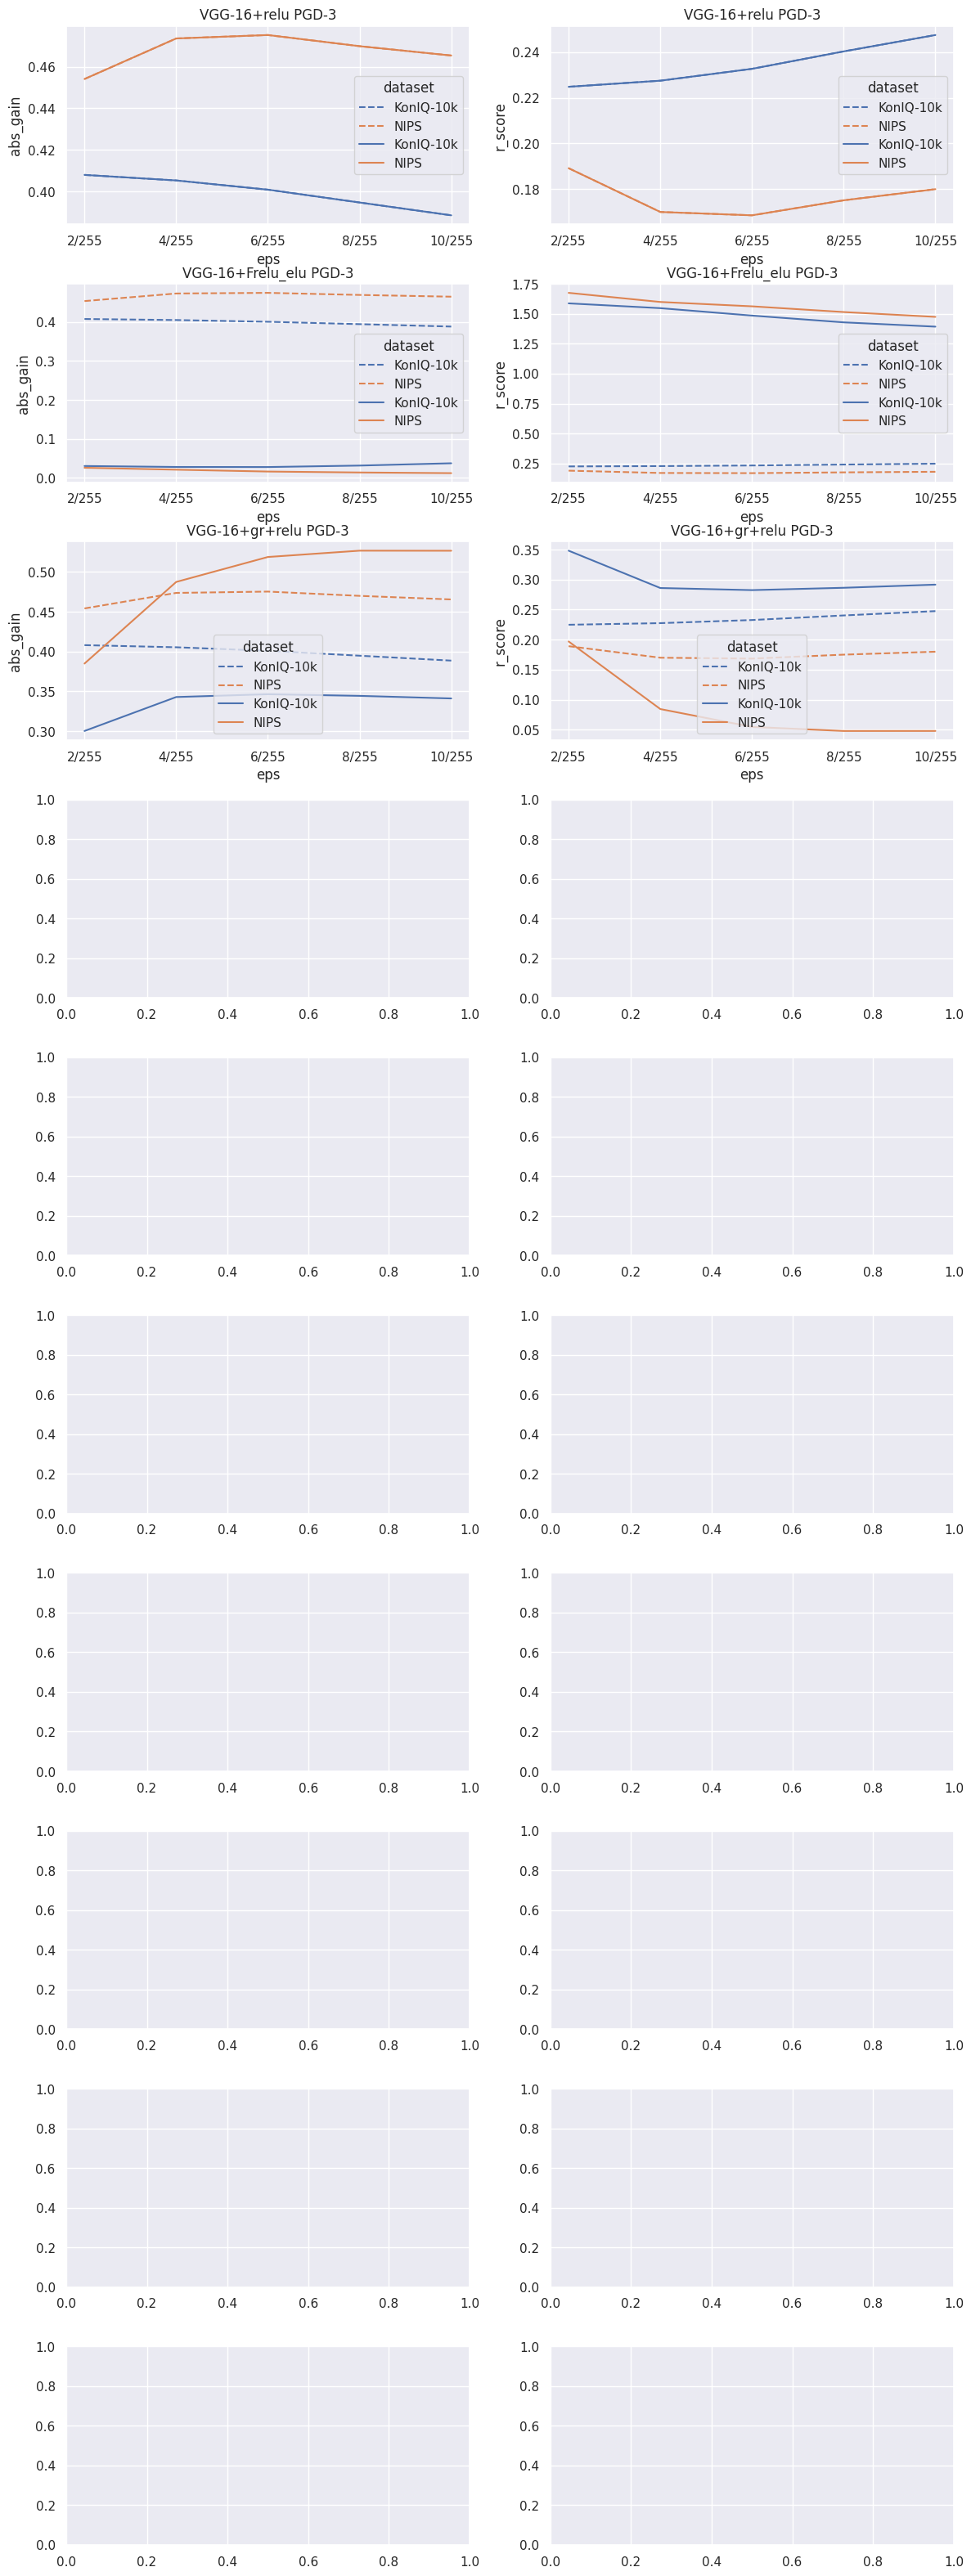

In [36]:
draw_plot(iterations=3, ax_rows=10, ax_cols=2, figsize=(14,40), wsapce=0.2, hspace=0.3)

min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.0 1.0 KonIQ-10k
min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.0 1.0 KonIQ-10k
min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.0 1.0 KonIQ-10k
min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.0 1.0 KonIQ-10k
min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.0 1.0 KonIQ-10k
min 2.206834554672241 max 3.822463989257813
min 2.206834554672241 max 3.822463989257813
0.0 1.0 NIPS
min 2.206834554672241 max 3.822463989257813
min 2.206834554672241 max 3.822463989257813
0.0 1.0 NIPS
min 2.206834554672241 max 3.822463989257813
min 2.206834554672241 max 3.822463989257813
0.0 1.0 NIPS
min 2.206834554672241 max 3.822463989257813
min 2.206834554672241 max 3.822463989257813
0.0 1.0 NIPS
min 2.206834554672241 max 3.822463989257813
min 2.206834

/tmp/ipykernel_1846767/4244345539.py:54: RuntimeWarning: divide by zero encountered in log10
  np.log10(


min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.0 1.0 KonIQ-10k
min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.0 1.0 KonIQ-10k
min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.0 1.0 KonIQ-10k
min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.0 1.0 KonIQ-10k
min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.0 1.0 KonIQ-10k
min 2.206834554672241 max 3.822463989257813
min 2.206834554672241 max 3.822463989257813
0.0 1.0 NIPS
min 2.206834554672241 max 3.822463989257813
min 2.206834554672241 max 3.822463989257813
0.0 1.0 NIPS
min 2.206834554672241 max 3.822463989257813
min 2.206834554672241 max 3.822463989257813
0.0 1.0 NIPS
min 2.206834554672241 max 3.822463989257813
min 2.206834554672241 max 3.822463989257813
0.0 1.0 NIPS
min 2.206834554672241 max 3.822463989257813
min 2.206834

/tmp/ipykernel_1846767/4244345539.py:54: RuntimeWarning: divide by zero encountered in log10
  np.log10(


min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.20033973677817515 0.9335946265213513 KonIQ-10k
min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.20033973677817515 0.9335946265213513 KonIQ-10k
min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.20033973677817515 0.9335946265213513 KonIQ-10k
min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.20033973677817515 0.9335946265213513 KonIQ-10k
min 1.5087409019470217 max 4.080042362213135
min 1.5087409019470217 max 4.080042362213135
0.20033973677817515 0.9335946265213513 KonIQ-10k
min 2.206834554672241 max 3.822463989257813
min 2.206834554672241 max 3.822463989257813
0.32423362056867333 0.9938117958969908 NIPS
min 2.206834554672241 max 3.822463989257813
min 2.206834554672241 max 3.822463989257813
0.32423362056867333 0.9938117958969908 NIPS
min 2.206834554672241 max 3.8224639892578

/tmp/ipykernel_1846767/4244345539.py:54: RuntimeWarning: invalid value encountered in log10
  np.log10(
/tmp/ipykernel_1846767/4244345539.py:54: RuntimeWarning: invalid value encountered in log10
  np.log10(
/tmp/ipykernel_1846767/4244345539.py:54: RuntimeWarning: invalid value encountered in log10
  np.log10(
/tmp/ipykernel_1846767/4244345539.py:54: RuntimeWarning: invalid value encountered in log10
  np.log10(


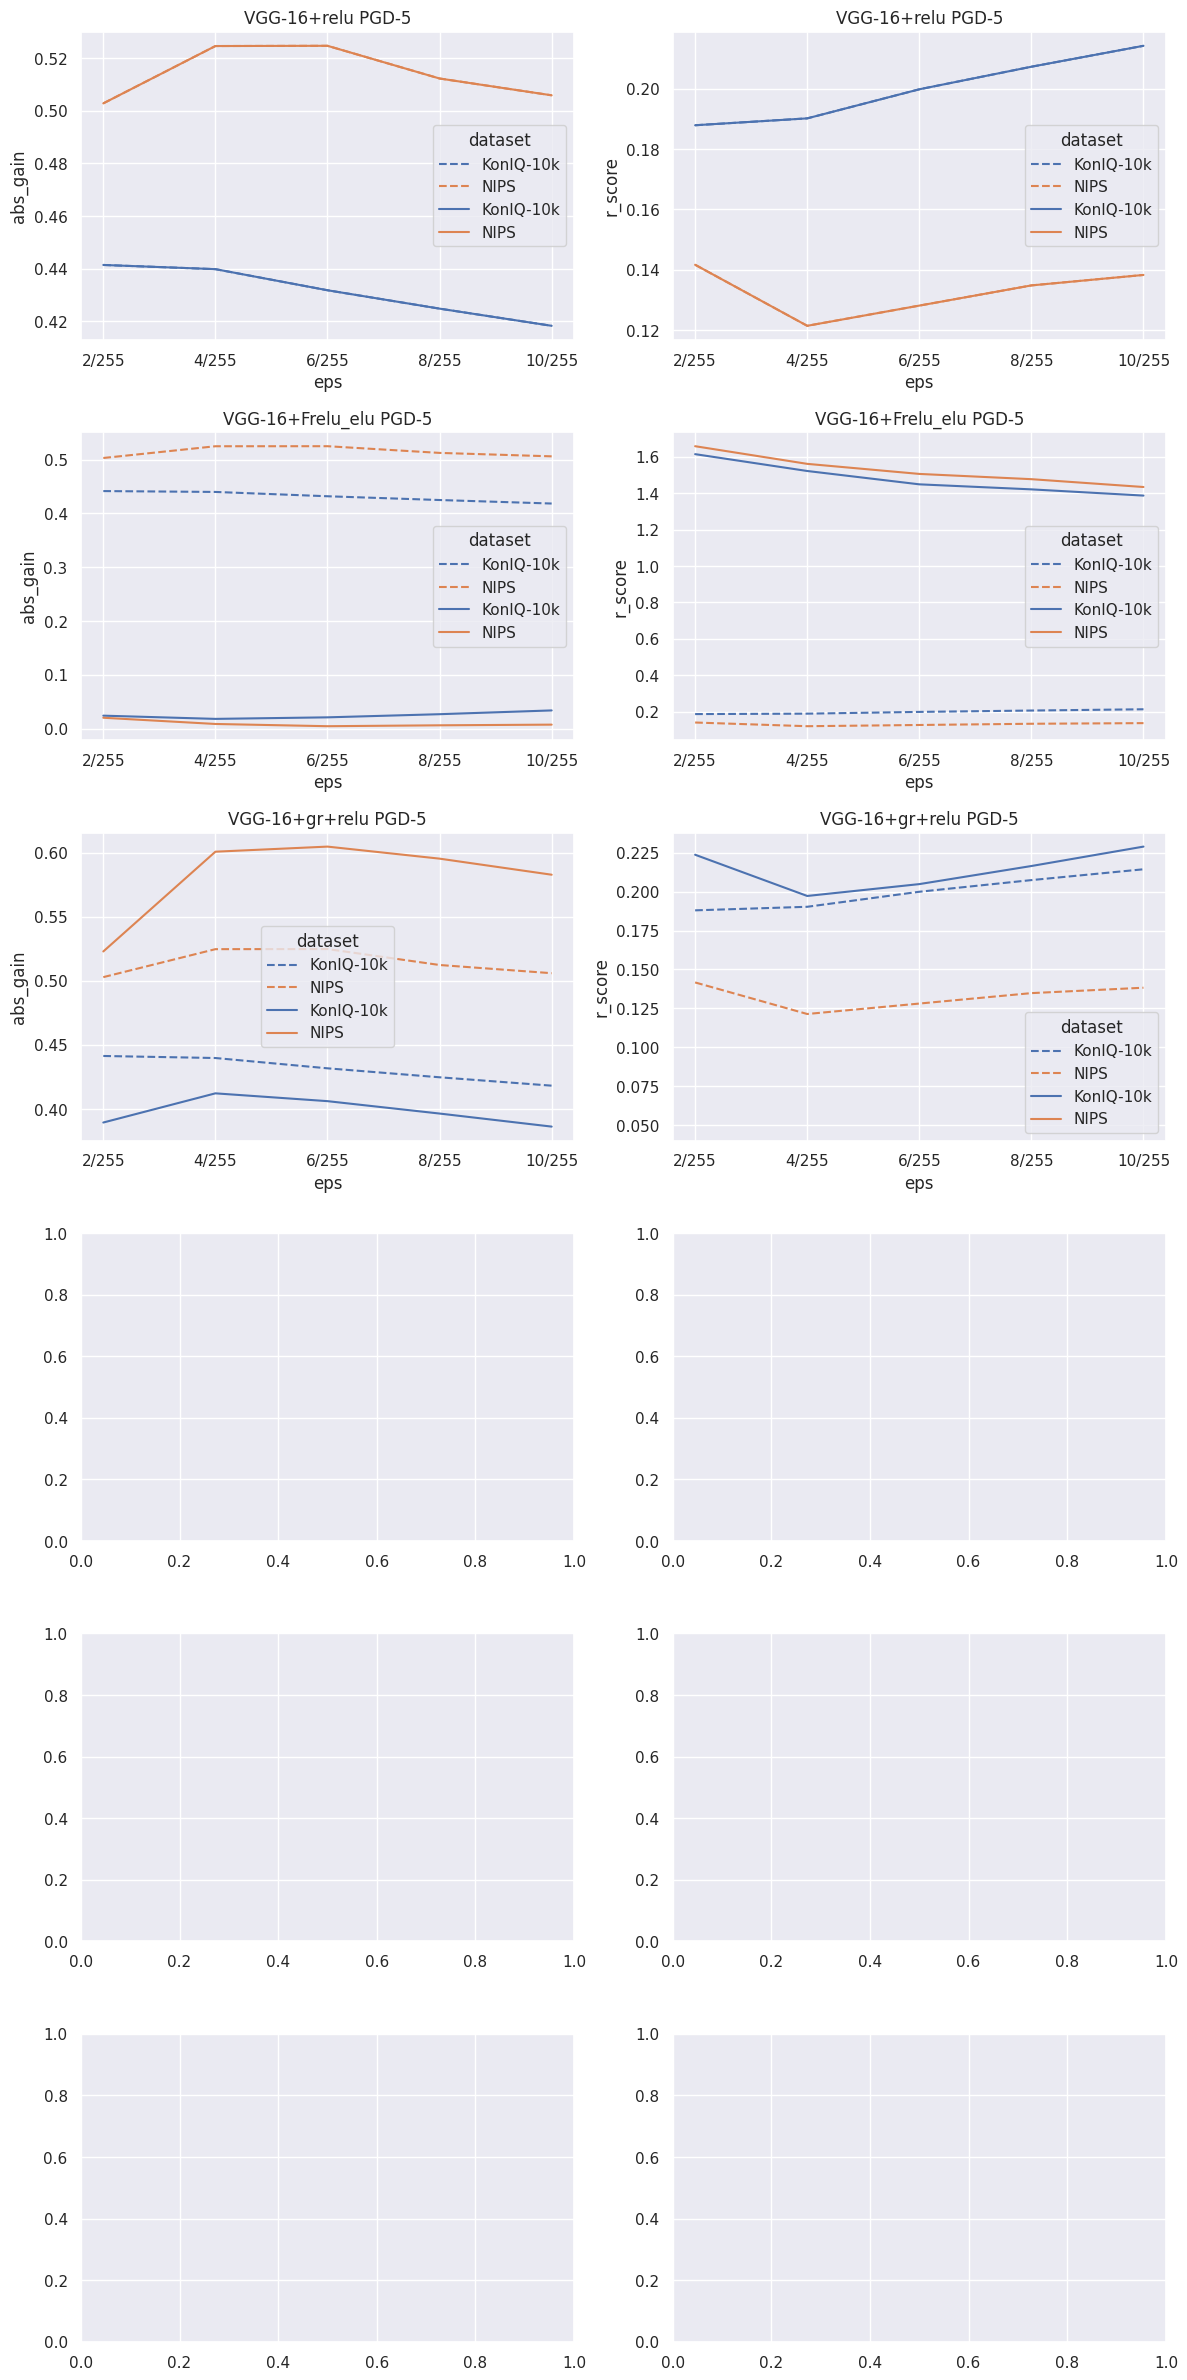

In [47]:
draw_plot(iterations=5, ax_rows=6, ax_cols=2, figsize=(14,30), wsapce=0.2, hspace=0.3)

In [44]:
draw_plot(iterations=8, ax_rows=20, ax_cols=2, figsize=(14,80), wsapce=0.2, hspace=0.3)

FileNotFoundError: [Errno 2] No such file or directory: '/home/28i_mel@lab.graphicon.ru/mnt/dione/28i_mel/DBCNN-results/KonIQ-10k_VGG-16+relu_PGD=8.csv'